In [24]:
#Connect google colab to your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
#PATH TO YOUR DRIVE FOLDER IF USING COLAB
os.chdir('drive/MyDrive/')

In [26]:
import pandas as pd
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

In [27]:
hand_landmarks = ['root','thumb_1','thumb_2','thumb_3',
                  'index_1','index_2','index_3','index_4',
                 'middle_1','middle_2','middle_3','middle_4',
                 'ring_1','ring_2','ring_3','ring_4',
                 'pinky_1','pinky_2','pinky_3','pinky_4']

In [38]:
def preprocess(letters : list, hand_landmarks : list, outliers : list, width : int, height : int, shape_factor : int) -> tuple([list,list]):
  X = [] #List of frames by order of videos and frames
  Y = [] #List of coordinates by order of videos and frames
  for letter in letters: #We browse each letter folder

    #Read dataset and withdraw useless rows 'hand_position'
    dataset = pd.read_csv(f'../course_dataset/ASL_letter_{letter}/annotations.csv')
    dataset = dataset.drop(dataset[dataset['joint'] == 'hand_position'].index,axis=0)

    nb_videos = len(os.listdir(f'../course_dataset/ASL_letter_{letter}/videos'))
    for video_idx in range(nb_videos): #We browse each letter video
        print(f"Letter {letter} : video_n°{video_idx}")

        if video_idx in outliers: #Videos of  different shape
          pass
          
        else:
          import copy
          #New list for each video to add to X/Y
          x_video = []
          y_video = []
        
          cap = cv2.VideoCapture(f'../course_dataset/ASL_letter_{letter}/videos/video_{video_idx}.mp4')
          video = dataset[dataset['video_idx']==video_idx]

          #Apply the reduction to coordinates
          video.loc[:,('x')] = video.loc[:,('x')].div(shape_factor)       
          video.loc[:,('y')] = video.loc[:,('y')].div(shape_factor)

          nb_frame = video['frame'].max()
          
          for frame in range(nb_frame+1):
              landmarks = []
              for joint in hand_landmarks:
                  
                  x = float(video['x'][(video['joint']==joint)&(video['frame']==frame)])
                  y = float(video['y'][(video['joint']==joint)&(video['frame']==frame)])

                  landmarks.append(y)#OpenCV flip coordinates
                  landmarks.append(x)
              y_video.append(np.array(landmarks).reshape(2*len(hand_landmarks),1))
          
          #Filling X list
          while cap.isOpened():
                  
                  ret,frame = cap.read()
                  
                  if type(frame) is type(None):
                      break

                  #Image configuration
                  image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)             
                  
                  #Resizing
                  dim = (int(image.shape[1]/shape_factor),int(image.shape[0]/shape_factor))
                  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

                  x_video.append(image)


          #There is difference between the number of frame read by CV2 and the number in CSV_annotations.
          #We take the lowest one to avoid issues.
          MIN = min(len(x_video),len(y_video))
          
          #Avoid the case when X/Y = []
          if video_idx == 0 and letters.index(letter)== 0:
              X = np.array(x_video[:MIN])
              
              Y = np.array(y_video[:MIN])
          else:
            X = np.concatenate((np.array(X), np.array(x_video[:MIN])),axis=0)

            Y = np.concatenate((np.array(Y), np.array(y_video[:MIN])),axis=0)
  return X, Y     

def build_model(input_shape : tuple([int,int,int]),output_shape : int) -> keras.models : 
  #First Block
  inputs = tf.keras.Input(shape=(input_shape), name="Input_Image") 
  x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',name='conv_32_1')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf. keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2),padding='valid')(x)

  #Second Block
  x = tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',name='conv_32_2')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf. keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2),padding='valid')(x)

  #Third block
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',name='conv_64_1')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf. keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2),padding='valid')(x)

  #Fourth block
  x = tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',name='conv_64_2')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x =tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',name='conv_64_3')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf. keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2),padding='valid')(x)

  #Fifth Block
  x = tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu',name='conv_128_1',kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf. keras.layers.MaxPool2D(pool_size=(2, 2),strides=(1, 1),padding='valid')(x)

  #Output Block
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(units=1024
                            ,activation='relu',use_bias=True,kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)

  outputs = tf.keras.layers.Dense(units=output_shape,activation='relu',use_bias=True)(x)
  model = tf.keras.Model(inputs=inputs,outputs=outputs)

  return model

def draw_landmarks(frame : np.array,y : list, color : str) -> np.array:
  image = copy.copy(frame)
  y = y.reshape(20,2)
  radius = 1
  
  if color=='red': #BGR
    color = (255, 0, 0)
  elif color=='blue':
    color = (0,0,255)
  else:
    color = (0,0,0)

  color_border = (255,255,255)
  thickness_circle = -1
  thickness_line = 2

  for landmark in range(20):
    image = cv2.circle(image, tuple(np.array(y[landmark,],int)), radius, color, thickness_circle)

  return image


In [28]:
letters=['A','B','C','L','R','U']
hand_landmarks = ['root','thumb_1','thumb_2','thumb_3',
                  'index_1','index_2','index_3','index_4',
                 'middle_1','middle_2','middle_3','middle_4',
                 'ring_1','ring_2','ring_3','ring_4',
                 'pinky_1','pinky_2','pinky_3','pinky_4']

outliers = [9,40] #Videos 9 and 40 are not 480x640
width, height, shape_factor = 480, 640, 4

input_shape = (int(width/shape_factor),int(height/shape_factor),3)
output_shape = len(hand_landmarks)*2 #2 coordinates per landmarks

In [41]:
X, Y = preprocess(letters=letters, 
                    hand_landmarks=hand_landmarks, 
                    outliers=outliers, 
                    width=width, height=height, shape_factor=shape_factor)

In [37]:
#If you don't have data preprocess
if not os.path.isfile('DATA_XY/X.npy'):

  X, Y = preprocess(letters=letters, 
                    hand_landmarks=hand_landmarks, 
                    outliers=outliers, 
                    width=width, height=height, shape_factor=shape_factor)

  os.makedirs('DATA_XY',exist_ok=True)
  np.save('DATA_XY/X.npy',X)
  np.save('DATA_XY/Y.npy',Y)
  
#If you already have Data preprocess
else:
  X = np.load('DATA_XY/X.npy')
  Y = np.load('DATA_XY/Y.npy')

In [30]:
#Splitting into Train, Valdiation, Test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [31]:
BATCH_SIZE = 32
EPOCHS = 500
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
#If you want to train the model
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-2,
    patience=100,
    verbose=1,
    mode="auto",
)
model.fit(train_dataset, validation_data=val_dataset,epochs=EPOCHS,verbose=1)

In [36]:
#If you want to load the model
model = keras.models.load_model('Trained_model')

In [33]:
#prediction = model.predict(X_test,batch_size=32,verbose=1)
prediction = model.predict(test_dataset,verbose=1)

381/381 [==============================] - 113s 293ms/step


In [34]:
difference = prediction-y_test.reshape(prediction.shape)
print(f"Mean error : {np.mean(difference)}")

Mean error : -0.22259805816643166


Text(0.5, 1.0, 'Test-predictioniction')

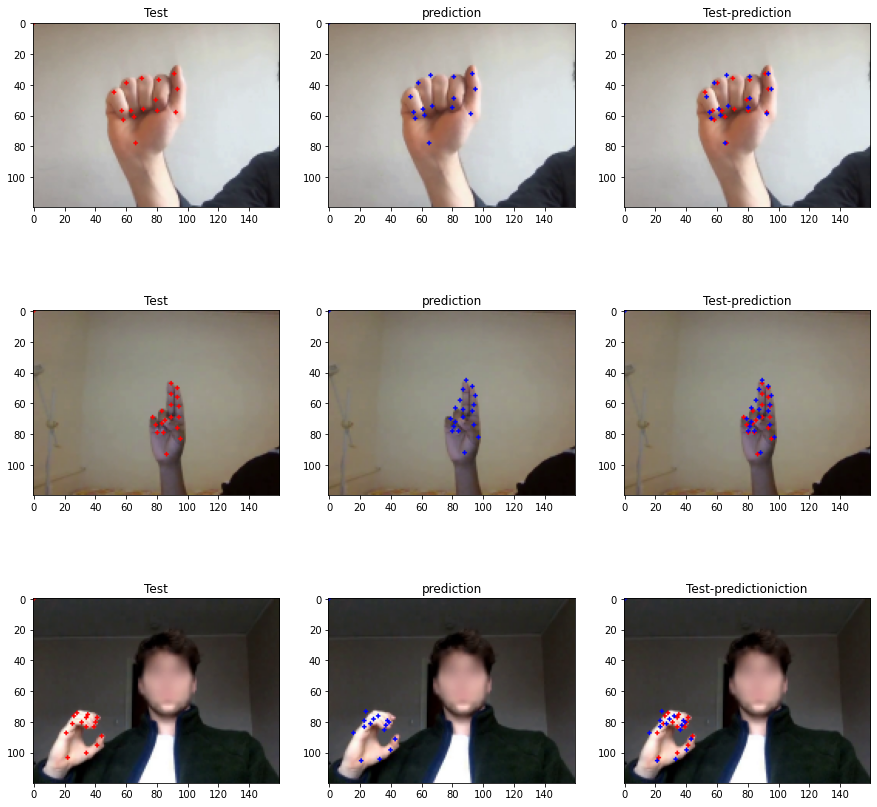

In [15]:
f, ax = plt.subplots(3,3,figsize=(15,15))
frame1 = draw_landmarks(X_test[56],y_test[56],'red')
ax[0,0].imshow(frame1)
ax[0,0].set_title('Test')
frame2 = draw_landmarks(X_test[56],prediction[56],'blue')
ax[0,1].imshow(frame2)
ax[0,1].set_title('prediction')
frame3 = draw_landmarks(frame1,prediction[56],'blue')
ax[0,2].imshow(frame3)
ax[0,2].set_title('Test-prediction')

frame1 = draw_landmarks(X_test[32],y_test[32],'red')
ax[1,0].imshow(frame1)
ax[1,0].set_title('Test')
frame2 = draw_landmarks(X_test[32],prediction[32],'blue')
ax[1,1].imshow(frame2)
ax[1,1].set_title('prediction')
frame3 = draw_landmarks(frame1,prediction[32],'blue')
ax[1,2].imshow(frame3)
ax[1,2].set_title('Test-prediction')

frame1 = draw_landmarks(X_test[3],y_test[3],'red')
ax[2,0].imshow(frame1)
ax[2,0].set_title('Test')
frame2 = draw_landmarks(X_test[3],prediction[3],'blue')
ax[2,1].imshow(frame2)
ax[2,1].set_title('prediction')
frame3 = draw_landmarks(frame1,prediction[3],'blue')
ax[2,2].imshow(frame3)
ax[2,2].set_title('Test-predictioniction')